# FEUP - AC
## Banking - Predicting a Loan Outcome

### Business understanding

##### Analysis of requirements with the end user
Text

##### Definition of business goals
Text

##### Translation of business goals into data mining goals
Text

### Exploratory data analysis

Let us start by importing the datasets.

In [1]:
import pandas as pd
import numpy as np

# Global settings
pd.set_option('display.max_columns', None)

COMP_DATA_SOURCE = "comp_data/"
DEV_DATA_SOURCE = "dev_data/"

# Read in the data; merge data for tables other than loans since they do not influence merges
accounts = pd.read_csv(DEV_DATA_SOURCE + 'account.csv', sep=';')

cards_dev = pd.read_csv(DEV_DATA_SOURCE + 'card.csv', sep=';')
cards_comp = pd.read_csv(COMP_DATA_SOURCE + 'card.csv', sep=';')
cards = pd.concat([cards_dev, cards_comp])

clients = pd.read_csv(DEV_DATA_SOURCE + 'client.csv', sep=';')

dispositions = pd.read_csv(DEV_DATA_SOURCE + 'disp.csv', sep=';')

districts = pd.read_csv(DEV_DATA_SOURCE + 'district.csv', sep=';')

transactions_dev = pd.read_csv(DEV_DATA_SOURCE + 'trans.csv', sep=';')
transactions_comp = pd.read_csv(COMP_DATA_SOURCE + 'trans.csv', sep=';')
transactions = pd.concat([transactions_dev, transactions_comp])

loans_dev = pd.read_csv(DEV_DATA_SOURCE + 'loan.csv', sep=';')
loans_comp = pd.read_csv(COMP_DATA_SOURCE + 'loan.csv', sep=';')

loans_dev.head()

C:\Users\joaoj\AppData\Local\Temp\ipykernel_12308\482001259.py:23: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  transactions_dev = pd.read_csv(DEV_DATA_SOURCE + 'trans.csv', sep=';')


,loan_id,account_id,date,amount,duration,payments,status
0,5314,1787,930705,96396,12,8033,-1
1,5316,1801,930711,165960,36,4610,1
2,6863,9188,930728,127080,60,2118,1
3,5325,1843,930803,105804,36,2939,1
4,7240,11013,930906,274740,60,4579,1


Plenty of analysis with graphs, distributions, outliers...

### Data preprocessing

Text

#### Processing accounts

The account spreadsheet relates it with the district and date in which it was created, as well with the frequency of issuance of statements with the owner.

The date comes in the from YYMMDD, which is easily extractable to the three different columns that it is aggregating. This will aid the model in detecting important patterns in the year of creation, for example, indicating a global economic crisis or prosperity when the person has created the account.

In [2]:
import src.preprocess.accounts as accpp
accounts = accpp.preprocess_accounts(accounts)
accounts.head()

,account_id,district_id,account_frequency,account_year,account_month,account_day
0,576,55,monthly issuance,93,1,1
1,3818,74,monthly issuance,93,1,1
2,704,55,monthly issuance,93,1,1
3,2378,16,monthly issuance,93,1,1
4,2632,24,monthly issuance,93,1,2


#### Processing credit cards

In the credit cards relation, the same concept applies to the date of issuance.

MORE TEXT

In [3]:
from src.preprocess.cards import preprocess_cards

cards = preprocess_cards(cards)
cards.head()

,card_id,disp_id,type,year,month,day
0,1005,9285,classic,93,11,7
1,104,588,classic,94,1,19
2,747,4915,classic,94,2,5
3,70,439,classic,94,2,8
4,577,3687,classic,94,2,15


#### Processing clients

In the clients relation, two foreign references and a date appear once again. However, regarding the latter one, there is an important difference: the day is the actual day plus fifty, if the client is a female, and so we can extract the gender too, here.

In [4]:
from src.preprocess.clients import preprocess_clients

clients = preprocess_clients(clients)
clients.head()

,client_id,district_id,year,month,day,gender
0,1,18,70,12,13,female
1,2,1,45,2,4,male
2,3,1,40,10,9,female
3,4,5,56,12,1,male
4,5,5,60,7,3,female


#### Processing dispositions

The disposition describes the rights of clients to operate accounts: only "owners" can ask for loans and issue permanent orders.

There is no clear way to merge this table with loans later on, since the loans table does not refer the disposition used for the loan. Instead, let's focus on the number of dispositions and the ratio of owners of an account, which will give an impression of the nature of the people able to control the account. All humans fight and cheat on each other, or build trust together. Let's discover that pattern in Czech Republic.

In [5]:
from src.preprocess.dispositions import preprocess_dispositions
dispositions = preprocess_dispositions(dispositions)
dispositions.head()

,disp_id,client_id,account_id,type,number_account_dispositions
0,1,1,1,OWNER,1
1,2,2,2,OWNER,2
2,3,3,2,DISPONENT,2
3,4,4,3,OWNER,2
4,5,5,3,DISPONENT,2


#### Processing districts

The districts relation is quite dense, describing the demographic data of a region. We can extract interesting measures here:

- The commited crimes growth ratio, derived from the evolution of the number of crimes from '95 to '96
- The unemployment rate growth ratio, derived from the evolution of the employment rate from '95 to '96

We also acknowledged that there was one region where the number of crimes and unemployment rate in '95 was not known (`?` was the appearance in the respective column). In order not to discard the entire region data, we'll simply assume that number to be the same as the matching record in '96.

In [6]:
from src.preprocess.districts import preprocess_districts
districts = preprocess_districts(districts)
districts.head()

,district_id,district_no_inhabitants,district_no_cities,district_urban_inhabitants_ratio,district_average_salary,district_unemployment_rate,districts_entrepreneurs_ratio,district_crimes_per_inhabitant,district_crime_growth,district_unemploymant_growth
0,1,1204953,1,100.0,12541,0.43,0.167,0.082250,1.156752,1.482759
1,2,88884,5,46.7,8507,1.85,0.132,0.030084,1.238536,1.107784
2,3,75232,5,41.7,8980,2.21,0.111,0.037391,0.996105,1.133333
3,4,149893,6,67.4,9753,5.05,0.109,0.039308,1.123570,1.088362
4,5,95616,6,51.4,9307,4.43,0.118,0.031794,1.162080,1.150649


#### Processing loans

The loans relation references an account and the date of loan, which can be extracted. The duration seems to be in months, so let us improve the name of the column. The amounts seems to be in `Czech korunas`, the czech currency, as hinted by the list of regions; we'll convert it to euros for better visualization and understanding of the upcoming results.

In [7]:
from src.preprocess.loans import preprocess_loans
loans_comp = preprocess_loans(loans_comp)
loans_dev = preprocess_loans(loans_dev)
loans_dev.head()

,loan_id,account_id,amount,duration_months,monthly_payment,status,year,month,day
0,5314,1787,3950.66,12,329.22,-1,93,7,5
1,5316,1801,6801.64,36,188.93,1,93,7,11
2,6863,9188,5208.20,60,86.80,1,93,7,28
3,5325,1843,4336.23,36,120.45,1,93,8,3
4,7240,11013,11259.84,60,187.66,1,93,9,6


#### Processing transactions

This table contains a lot of information that we cannot directly relate to a loan.

Let us first extract the date and make the withdrawal amounts actually negative, to give the model an impression of the direction of the money flow in and out of the bank.

For now, let us extract some statistical data related to the accounts, which we'll relate to the loans table.

In [8]:
from src.preprocess.transactions import preprocess_transactions
transactions = preprocess_transactions(transactions)

transactions.head()

,trans_id,account_id,type,operation,amount,balance,k_symbol,bank,account,year,month,day
0,1548749,5270,credit,credit in cash,32.79,32.79,NaN,NaN,NaN,93,1,13
1,1548750,5270,credit,collection from another bank,1833.98,1866.76,NaN,IJ,80269753.0,93,1,14
2,3393738,11265,credit,credit in cash,40.98,40.98,NaN,NaN,NaN,93,1,14
3,3122924,10364,credit,credit in cash,45.08,45.08,NaN,NaN,NaN,93,1,17
4,1121963,3834,credit,credit in cash,28.69,28.69,NaN,NaN,NaN,93,1,19


#### Feature engineering

Text

##### Getting the average account balance based on the transactions

In [9]:
from src.feature_engineering.merge import merge_account_transactions
accounts = merge_account_transactions(accounts, transactions)
accounts.head(50)

,account_id,district_id,account_frequency,account_year,account_month,account_day,average_account_credit_per_month,average_account_debit_per_month,average_account_balance_per_month
0,576,55,monthly issuance,93,1,1,1035.715833,904.202500,999.522185
1,3818,74,monthly issuance,93,1,1,3151.655833,2984.252500,1767.192783
2,704,55,monthly issuance,93,1,1,3142.233333,3003.023333,1430.753626
3,2378,16,monthly issuance,93,1,1,7309.517500,6997.125833,2333.499442
4,2632,24,monthly issuance,93,1,2,2577.331667,2486.182500,1324.460590
5,1972,77,monthly issuance,93,1,2,883.964167,792.201667,923.907229
6,1539,1,issuance after transaction,93,1,3,4044.915000,4010.747500,1034.257598
7,793,47,monthly issuance,93,1,3,575.238333,479.689167,978.297846
8,2484,74,monthly issuance,93,1,3,2669.864167,2592.596667,1304.756920
9,1695,76,monthly issuance,93,1,3,5946.183333,5640.082500,2110.171398


##### Clusters

In [10]:
import src.stats.clusters as clusters
#clusters.cluster_monthly_payment_per_loan_amount(loans_dev)
#clusters.cluster_monthly_payment_per_loan_amount(loans_comp)

In [11]:
table = clusters.cluster_transactions(transactions)
accounts = pd.merge(accounts, table, on='account_id', how='left')
accounts.head()

(3724, 10)


,account_id,district_id,account_frequency,account_year,account_month,account_day,average_account_credit_per_month,average_account_debit_per_month,average_account_balance_per_month,transaction_profile
0,576,55,monthly issuance,93,1,1,1035.715833,904.202500,999.522185,2.0
1,3818,74,monthly issuance,93,1,1,3151.655833,2984.252500,1767.192783,3.0
2,704,55,monthly issuance,93,1,1,3142.233333,3003.023333,1430.753626,3.0
3,2378,16,monthly issuance,93,1,1,7309.517500,6997.125833,2333.499442,2.0
4,2632,24,monthly issuance,93,1,2,2577.331667,2486.182500,1324.460590,3.0


In [12]:
new_districts_table = clusters.cluster_districts(districts)
print(districts.shape)
print(new_districts_table.shape)

new_districts_table.head()

(77, 11)
(77, 3)


,district_id,districts_profile,district_average_salary
0,1,1,12541
1,2,0,8507
2,3,8,8980
3,4,2,9753
4,5,0,9307


#### Merging the data

The model will be working on the `loans` table, since the target variable belongs to it. The one foreign key of that table is `account_id`; so, to feed the model with more information about the context of the loan, we should relate concepts to the account for each table.

##### Relating clients to districts

In [13]:
import src.feature_engineering.merge as merge

clients = merge.merge_client_districts(clients, new_districts_table)
clients.rename(columns={'district_id': 'client_district_id'}, inplace=True)
clients.head()

,client_id,owner_district_id,year,month,day,gender,owner_districts_profile,owner_district_average_salary
0,1,18,70,12,13,female,8,8968
1,2,1,45,2,4,male,1,12541
2,3,1,40,10,9,female,1,12541
3,4,5,56,12,1,male,0,9307
4,5,5,60,7,3,female,0,9307


##### Relating dispositions to clients

In [14]:
dispositions = merge.merge_dispositions_clients(dispositions, clients)
dispositions.head()

,disp_id,account_id,type,number_account_dispositions,owner_district_id,client_year,client_month,client_day,client_gender,owner_districts_profile,owner_district_average_salary
0,1,1,OWNER,1,18,70,12,13,female,8,8968
1,2,2,OWNER,2,1,45,2,4,male,1,12541
2,3,2,DISPONENT,2,1,40,10,9,female,1,12541
3,4,3,OWNER,2,5,56,12,1,male,0,9307
4,5,3,DISPONENT,2,5,60,7,3,female,0,9307


##### Relating dispositions to cards

In [15]:
dispositions = merge.merge_dispositions_cards(dispositions, cards) # cards are not enough; too many nans, check and discard
dispositions.head()


,disp_id,account_id,type,number_account_dispositions,owner_district_id,client_year,client_month,client_day,client_gender,owner_districts_profile,owner_district_average_salary,card_type
0,1,1,OWNER,1,18,70,12,13,female,8,8968,missing
1,2,2,OWNER,2,1,45,2,4,male,1,12541,missing
2,3,2,DISPONENT,2,1,40,10,9,female,1,12541,missing
3,4,3,OWNER,2,5,56,12,1,male,0,9307,missing
4,5,3,DISPONENT,2,5,60,7,3,female,0,9307,missing


##### Relating owner dispositions to accounts

Only owners can ask for loans. This way, we can directly relate an account to its owner client.

In [16]:
accounts = merge.merge_account_dispositions(accounts, dispositions)
accounts.head()

,account_id,district_id,account_frequency,account_year,account_month,account_day,average_account_credit_per_month,average_account_debit_per_month,average_account_balance_per_month,transaction_profile,number_account_dispositions,owner_district_id,owner_year,owner_month,owner_day,owner_gender,owner_districts_profile,owner_district_average_salary,card_type
0,576,55,monthly issuance,93,1,1,1035.715833,904.202500,999.522185,2.0,2,74,36,1,11,female,3,10673,missing
1,3818,74,monthly issuance,93,1,1,3151.655833,2984.252500,1767.192783,3.0,2,1,35,4,2,male,1,12541,missing
2,704,55,monthly issuance,93,1,1,3142.233333,3003.023333,1430.753626,3.0,2,22,45,1,14,male,4,8620,missing
3,2378,16,monthly issuance,93,1,1,7309.517500,6997.125833,2333.499442,2.0,1,16,75,3,24,female,0,8427,missing
4,2632,24,monthly issuance,93,1,2,2577.331667,2486.182500,1324.460590,3.0,1,24,38,8,12,male,5,8991,missing


In [17]:
accounts = merge.merge_accounts_districts(accounts, new_districts_table)
accounts.rename(columns={'district_id': 'account_district_id'}, inplace=True)
accounts.head()

,account_id,account_district_id,account_frequency,account_year,account_month,account_day,average_account_credit_per_month,average_account_debit_per_month,average_account_balance_per_month,transaction_profile,number_account_dispositions,owner_district_id,owner_year,owner_month,owner_day,owner_gender,owner_districts_profile,owner_district_average_salary,card_type,account_districts_profile,account_district_average_salary
0,576,55,monthly issuance,93,1,1,1035.715833,904.202500,999.522185,2.0,2,74,36,1,11,female,3,10673,missing,2,8743
1,3818,74,monthly issuance,93,1,1,3151.655833,2984.252500,1767.192783,3.0,2,1,35,4,2,male,1,12541,missing,3,10673
2,704,55,monthly issuance,93,1,1,3142.233333,3003.023333,1430.753626,3.0,2,22,45,1,14,male,4,8620,missing,2,8743
3,2378,16,monthly issuance,93,1,1,7309.517500,6997.125833,2333.499442,2.0,1,16,75,3,24,female,0,8427,missing,0,8427
4,2632,24,monthly issuance,93,1,2,2577.331667,2486.182500,1324.460590,3.0,1,24,38,8,12,male,5,8991,missing,5,8991


##### Loading the loans table with data

In [18]:
accounts.rename(columns = {'year':'account_year', 'month':'account_month', 'day':'account_day', 'frequency': 'account_frequency', 'district_id': 'account_district_id'}, inplace=True)
loans_dev = loans_dev.merge(accounts, on="account_id", how="left")
loans_comp = loans_comp.merge(accounts, on="account_id", how="left")
loans_dev.drop(columns=['account_id'], inplace=True)
loans_comp.drop(columns=['account_id'], inplace=True)
loans_dev.head()

,loan_id,amount,duration_months,monthly_payment,status,year,month,day,account_district_id,account_frequency,account_year,account_month,account_day,average_account_credit_per_month,average_account_debit_per_month,average_account_balance_per_month,transaction_profile,number_account_dispositions,owner_district_id,owner_year,owner_month,owner_day,owner_gender,owner_districts_profile,owner_district_average_salary,card_type,account_districts_profile,account_district_average_salary
0,5314,3950.66,12,329.22,-1,93,7,5,30,weekly issuance,93,3,22,205.942500,0.000000,502.047500,4.0,1,30,47,7,22,female,0,9650,missing,0,9650
1,5316,6801.64,36,188.93,1,93,7,11,46,monthly issuance,93,2,13,1570.310000,1820.542500,1915.255852,4.0,1,46,68,7,22,male,9,8369,missing,9,8369
2,6863,5208.20,60,86.80,1,93,7,28,45,monthly issuance,93,2,8,513.293333,562.220000,1048.655833,4.0,1,45,36,6,2,male,8,8390,missing,8,8390
3,5325,4336.23,36,120.45,1,93,8,3,12,monthly issuance,93,1,30,704.387143,705.058000,1382.883963,4.0,1,14,40,4,20,female,2,10045,missing,9,8754
4,7240,11259.84,60,187.66,1,93,9,6,1,weekly issuance,93,2,14,1617.838571,1606.653333,2122.977279,4.0,1,63,78,9,7,male,0,8288,missing,1,12541


##### Feature selection and engineering on the loans table

In [19]:
import src.preprocess.util as utils
loans_dev['age_at_loan'] = loans_dev.apply(lambda row: utils.extract_age(row), axis=1)
loans_comp['age_at_loan'] = loans_comp.apply(lambda row: utils.extract_age(row), axis=1)

#loans_dev = loans_dev.drop(columns=["account_month", "account_day", "month", "day", "owner_day",\
#    "owner_month", "account_districts_profile", "owner_districts_profile", "transaction_profile", "account_district_average_salary", "owner_district_average_salary"])
#loans_comp = loans_comp.drop(columns=["account_month", "account_day", "month", "day", "owner_day", \
#    "owner_month", "account_districts_profile", "owner_districts_profile", "transaction_profile", "account_district_average_salary", "owner_district_average_salary"])
loans_dev = loans_dev.drop(columns=["account_month", "account_day", "month", "day", "owner_day",\
   "owner_month", "loan_id", "monthly_payment", "account_district_id", "owner_district_id", "owner_month"])
loans_comp = loans_comp.drop(columns=["account_month", "account_day", "month", "day", "owner_day",\
   "owner_month", "loan_id", "monthly_payment", "account_district_id", "owner_district_id", "owner_month"])
   

In [20]:
loans_dev.columns

Index(['amount', 'duration_months', 'status', 'year', 'account_frequency',
       'account_year', 'average_account_credit_per_month',
       'average_account_debit_per_month', 'average_account_balance_per_month',
       'transaction_profile', 'number_account_dispositions', 'owner_year',
       'owner_gender', 'owner_districts_profile',
       'owner_district_average_salary', 'card_type',
       'account_districts_profile', 'account_district_average_salary',
       'age_at_loan'],
      dtype='object')

In [49]:
loans_dev.head(5)

,amount,duration_months,status,year,account_frequency,account_year,average_account_credit_per_month,average_account_debit_per_month,average_account_balance_per_month,transaction_profile,number_account_dispositions,owner_year,owner_gender,owner_districts_profile,owner_district_average_salary,card_type,account_districts_profile,account_district_average_salary,age_at_loan
0,3950.66,12,-1,93,weekly issuance,93,205.942500,0.000000,502.047500,4.0,1,47,female,0,9650,missing,0,9650,3
1,6801.64,36,1,93,monthly issuance,93,1570.310000,1820.542500,1915.255852,4.0,1,68,male,9,8369,missing,9,8369,1
2,5208.20,60,1,93,monthly issuance,93,513.293333,562.220000,1048.655833,4.0,1,36,male,8,8390,missing,8,8390,3
3,4336.23,36,1,93,monthly issuance,93,704.387143,705.058000,1382.883963,4.0,1,40,female,2,10045,missing,9,8754,3
4,11259.84,60,1,93,weekly issuance,93,1617.838571,1606.653333,2122.977279,4.0,1,78,male,0,8288,missing,1,12541,0


### Training the model

#### One hot encoding and missing values imputter

In [22]:
from sklearn.impute import SimpleImputer

print(len(loans_dev.columns) == len(loans_comp.columns))

loans_dev = utils.extract_categorical(loans_dev, "account_frequency")
loans_comp = utils.extract_categorical(loans_comp, "account_frequency")
loans_dev = utils.extract_categorical(loans_dev, "card_type")
loans_comp = utils.extract_categorical(loans_comp, "card_type")
loans_dev = utils.extract_categorical(loans_dev, "owner_gender")
loans_comp = utils.extract_categorical(loans_comp, "owner_gender")

loans_dev.head()

True


,amount,duration_months,status,year,account_year,average_account_credit_per_month,average_account_debit_per_month,average_account_balance_per_month,transaction_profile,number_account_dispositions,owner_year,owner_districts_profile,owner_district_average_salary,account_districts_profile,account_district_average_salary,age_at_loan,issuance after transaction,monthly issuance,weekly issuance,classic,gold,junior,missing,female,male
0,3950.66,12,-1,93,93,205.942500,0.000000,502.047500,4.0,1,47,0,9650,0,9650,3,0,0,1,0,0,0,1,1,0
1,6801.64,36,1,93,93,1570.310000,1820.542500,1915.255852,4.0,1,68,9,8369,9,8369,1,0,1,0,0,0,0,1,0,1
2,5208.20,60,1,93,93,513.293333,562.220000,1048.655833,4.0,1,36,8,8390,8,8390,3,0,1,0,0,0,0,1,0,1
3,4336.23,36,1,93,93,704.387143,705.058000,1382.883963,4.0,1,40,2,10045,9,8754,3,0,1,0,0,0,0,1,1,0
4,11259.84,60,1,93,93,1617.838571,1606.653333,2122.977279,4.0,1,78,0,8288,1,12541,0,0,0,1,0,0,0,1,0,1


In [23]:
loans_dev.columns

Index(['amount', 'duration_months', 'status', 'year', 'account_year',
       'average_account_credit_per_month', 'average_account_debit_per_month',
       'average_account_balance_per_month', 'transaction_profile',
       'number_account_dispositions', 'owner_year', 'owner_districts_profile',
       'owner_district_average_salary', 'account_districts_profile',
       'account_district_average_salary', 'age_at_loan',
       'issuance after transaction', 'monthly issuance', 'weekly issuance',
       'classic', 'gold', 'junior', 'missing', 'female', 'male'],
      dtype='object')

amount                              -0.128237
duration_months                     -0.003537
status                               1.000000
year                                 0.024336
account_year                         0.053818
average_account_credit_per_month     0.084741
average_account_debit_per_month      0.079524
average_account_balance_per_month    0.207112
transaction_profile                 -0.107373
number_account_dispositions          0.219900
owner_year                           0.033509
owner_districts_profile             -0.033226
owner_district_average_salary        0.013187
account_districts_profile           -0.034837
account_district_average_salary      0.023895
age_at_loan                         -0.040879
issuance after transaction          -0.056889
monthly issuance                     0.071589
weekly issuance                     -0.044766
classic                              0.063859
gold                                 0.031634
junior                            

<AxesSubplot: >

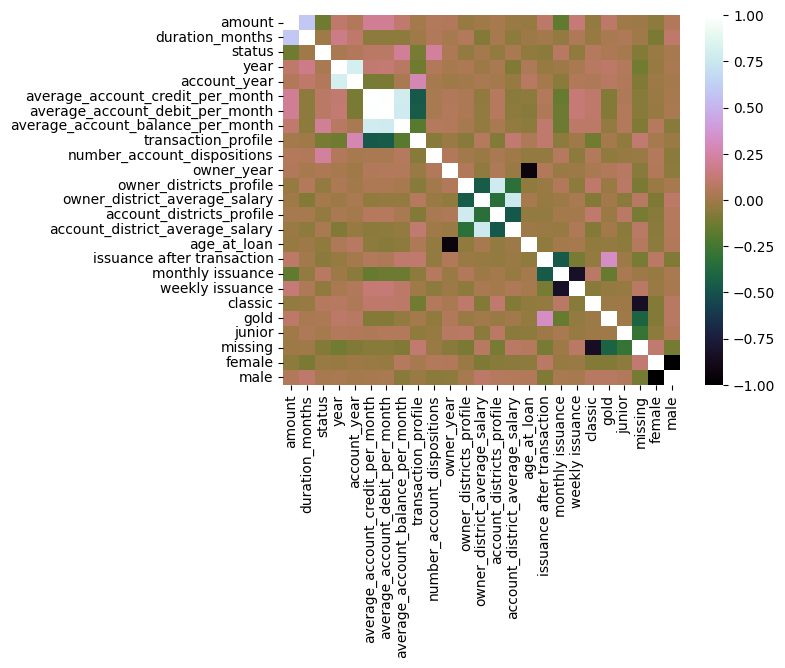

In [24]:
import seaborn as sns


corr_values=loans_dev.corr(method='pearson')
print(corr_values['status'])
sns.heatmap(corr_values,cmap=sns.color_palette("cubehelix", as_cmap=True))

#### Predicting and evaluating with the main model

Evaluate classification model performance with loans table

In [71]:
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.neighbors import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.linear_model import *
from sklearn.gaussian_process import *
from sklearn.naive_bayes import *
from sklearn.neural_network import *
from sklearn.preprocessing import *
from src.model.model import *

from sklearn.pipeline import Pipeline

x_train, x_test, y_train, y_test = train_test_split_unbalanced(loans_dev, "status", sampling_strategy="tomek_links", \
    sort_by_date=False, train_ratio=0.8, random_state=0)

clf = Pipeline([
    ('select_k_best', SelectKBest()),
    ('classifier', RandomForestClassifier(n_estimators=200, random_state=0))
])

# Train it with data
clf.fit(x_train, y_train)

if len(y_test) > 0: # not training with entire dataset
    # Predict the test data for dev and evaluate
    predictions_dev = clf.predict(x_test)
    predictions_dev_prob = clf.predict_proba(x_test)

    # Evaluate
    print('Recall: ', recall_score(y_test, predictions_dev, pos_label=-1))
    print('Accuracy: ', accuracy_score(y_test, predictions_dev))
    print('Precision: ', precision_score(y_test, predictions_dev, pos_label=-1))
    print('F-Score: ', f1_score(y_test, predictions_dev, pos_label=-1))
    print("AUROC: ", roc_auc_score(y_test, predictions_dev_prob[:, 1]))
    print("Dev self_confidence_score: ", self_confidence_score(predictions_dev_prob[:, 1]))

    # Write the dev predictions to a file
    predictions_dev_id = x_test["loan_id"]
    predictions_dev_debt = [x[0] for x in predictions_dev_prob]
    predictions_df_dev = pd.DataFrame({"Id": predictions_dev_id, "Predicted": predictions_dev_debt, "Actual": y_test})
    predictions_df_dev.to_csv("output/predictions_dev.csv", index=False)

# Predict the competition data with probabilities
loans_comp_indep = loans_comp.drop(axis=1, columns=["status"])
predictions_comp_prob = clf.predict_proba(loans_comp_indep)
predictions_comp = clf.predict(loans_comp_indep)
print("Competition self_confidence_score: ", self_confidence_score(predictions_comp_prob[:, 1]))

# Write the comp predictions to a file
predictions_comp_debt = [x[0] for x in predictions_comp_prob]
predictions_comp_id = loans_comp["loan_id"].tolist()
predictions_df_comp = pd.DataFrame({"Id": predictions_comp_id, "Predicted": predictions_comp_debt})
predictions_df_comp.to_csv("output/predictions_comp.csv", index=False)

Competition self_confidence_score:  0.063009361508888


#### Predicting and evaluating with multiple pipelines

Text

In [101]:
import warnings
warnings.filterwarnings("ignore")

no_different_splits = 10 # change this to a lower number if you want to test the code faster
samplers = [
  #None,
  "svmsmote", # over-sampling
  #"tomek_links", # under-sampling
  #"smote_tomek", # over- and under-sampling
]
feature_selectors = [
  #None,
  #VarianceThreshold(threshold=0.16), # remove features with low variance
  #SelectKBest(f_classif, k=5), # keep only the 10 best features
  SelectKBest(f_classif, k=10), # keep only the 10 best features
  #"remove_day_months_remove_year",
  #"remove_districts_remove_clusters",
  #"remove_transactions",
]
classifiers = [
    # neighbors
    KNeighborsClassifier(),
    # linear learners
    SVC(random_state=0, probability=True),
    # probability-based
    GaussianNB(),
    # trees
    DecisionTreeClassifier(random_state=0),
    # ensemble methods
    RandomForestClassifier(random_state=0, n_estimators=200),
    AdaBoostClassifier(random_state=0, n_estimators=50),
    # neural networks
    MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300),
]

aucs = {}
recalls = {}
precisions = {}
accuracies = {}
# populate aucs
for sampler in samplers:
  for feature_selector in feature_selectors:
    for classifier in classifiers:
      print("|", end="") # simple progress indicator
      aucs[(sampler, feature_selector, classifier)] = []
      recalls[(sampler, feature_selector, classifier)] = []
      precisions[(sampler, feature_selector, classifier)] = []
      accuracies[(sampler, feature_selector, classifier)] = []

print("")
for sampler in samplers:
  for feature_selector in feature_selectors:
    for classifier in classifiers:
      print("|", end="") # simple progress indicator
      for random_state in range(no_different_splits): # split differently each time

        x_train, x_test, y_train, y_test = train_test_split_unbalanced(loans_dev, "status", sampling_strategy=sampler, \
          sort_by_date=False, train_ratio=0.8, random_state=random_state, drop_columns=["loan_id"])

        if feature_selector is not None:
          if isinstance(feature_selector, str):
            if "remove_day_months" in feature_selector:
              x_train = x_train.drop(columns=["account_month", "account_day", "month", "day", "owner_day", "owner_month"])
              x_test = x_test.drop(columns=["account_month", "account_day", "month", "day", "owner_day", "owner_month"])
            elif "remove_clusters" in feature_selector:
              x_train = x_train.drop(columns=["transaction_profile", "owner_districts_profile", "account_districts_profile"])
              x_test = x_test.drop(columns=["transaction_profile", "owner_districts_profile", "account_districts_profile"])
            elif "remove_districts" in feature_selector:
              x_train = x_train.drop(columns=["account_district_id", "owner_district_id"])
              x_test = x_test.drop(columns=["account_district_id", "owner_district_id"])
            elif "remove_transactions" in feature_selector:
              x_train = x_train.drop(columns=["average_account_balance_per_month", "average_account_debit_per_month", "average_account_credit_per_month"])
              x_test = x_test.drop(columns=["average_account_balance_per_month", "average_account_debit_per_month", "average_account_credit_per_month"])
            elif "remove_year" in feature_selector:
              x_train = x_train.drop(columns=["year", "owner_year", "account_year"])
              x_test = x_test.drop(columns=["year", "owner_year", "account_year"])
          else:
            feature_selector.fit(x_train, y_train)
            x_train = feature_selector.transform(x_train)
            x_test = feature_selector.transform(x_test)

        # Train it with data
        classifier.fit(x_train, y_train)

        # Predict the test data for dev and evaluate
        predictions_dev = classifier.predict(x_test)
        predictions_dev_prob = classifier.predict_proba(x_test)

        # Evaluate
        auc = roc_auc_score(y_test, predictions_dev_prob[:, 1])
        aucs[(sampler, feature_selector, classifier)] += [auc]
        recall = recall_score(y_test, predictions_dev, pos_label=-1)
        recalls[(sampler, feature_selector, classifier)] += [recall]
        precision = precision_score(y_test, predictions_dev, pos_label=-1)
        precisions[(sampler, feature_selector, classifier)] += [precision]
        accuracy = accuracy_score(y_test, predictions_dev)
        accuracies[(sampler, feature_selector, classifier)] += [accuracy]

print("")
sorted_aucs = sorted(aucs.items(), key=lambda x: sum(x[1]), reverse=True)
for auc in sorted_aucs:
  print(auc[0])
  print(auc[1])
  print(sum(auc[1]) / len(auc[1]), min(auc[1]), max(auc[1]))
  print("")

# Write aucs to file
with open("output/aucs.txt", "w") as f:
  for auc in sorted_aucs:
    f.write(str(auc[0]) + " " + str(auc[1]) + " " + str(sum(auc[1]) / len(auc[1])))
    f.write("\n")

# Write recalls to file
with open("output/recalls.txt", "w") as f:
  for recall in sorted(recalls.items(), key=lambda x: sum(x[1]), reverse=True):
    f.write(str(recall[0]) + " " + str(sum(recall[1]) / len(recall[1])))
    f.write("\n")

# Write precisions to file
with open("output/precisions.txt", "w") as f:
  for precision in sorted(precisions.items(), key=lambda x: sum(x[1]), reverse=True):
    f.write(str(precision[0]) + " " + str(sum(precision[1]) / len(precision[1])))
    f.write("\n")

# Write accuracies to file
with open("output/accuracies.txt", "w") as f:
  for accuracy in sorted(accuracies.items(), key=lambda x: sum(x[1]), reverse=True):
    f.write(str(accuracy[0]) + " " + str(sum(accuracy[1]) / len(accuracy[1])))
    f.write("\n")

|||||||
|||||||
('svmsmote', SelectKBest(), AdaBoostClassifier(random_state=0))
[0.9458333333333333, 0.6821480406386067, 0.7627118644067796, 0.7857142857142857, 0.7114197530864197, 0.7563352826510721, 0.7619738751814223, 0.6595041322314049, 0.7454545454545455, 0.7112068965517242]
0.7522302009249594 0.6595041322314049 0.9458333333333333

('svmsmote', SelectKBest(), RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=0))
[0.9138888888888889, 0.6233671988388969, 0.6537530266343826, 0.775, 0.7299382716049383, 0.8196881091617934, 0.7445573294629898, 0.7140495867768595, 0.7867768595041322, 0.6088362068965517]
0.7369855477769434 0.6088362068965517 0.9138888888888889

('svmsmote', SelectKBest(), GaussianNB())
[0.8, 0.6850507982583454, 0.5375302663438256, 0.7232142857142858, 0.6774691358024691, 0.8011695906432748, 0.6269956458635704, 0.543801652892562, 0.7669421487603305, 0.6185344827586207]
0.6780708007037285 0.5375302663438256 0.8011695906432748

('svmsmote', SelectKBest(), SVC(p

#### Extracting results to plots

AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)
AxesSubplot(0.125,0.11;0.775x0.77)


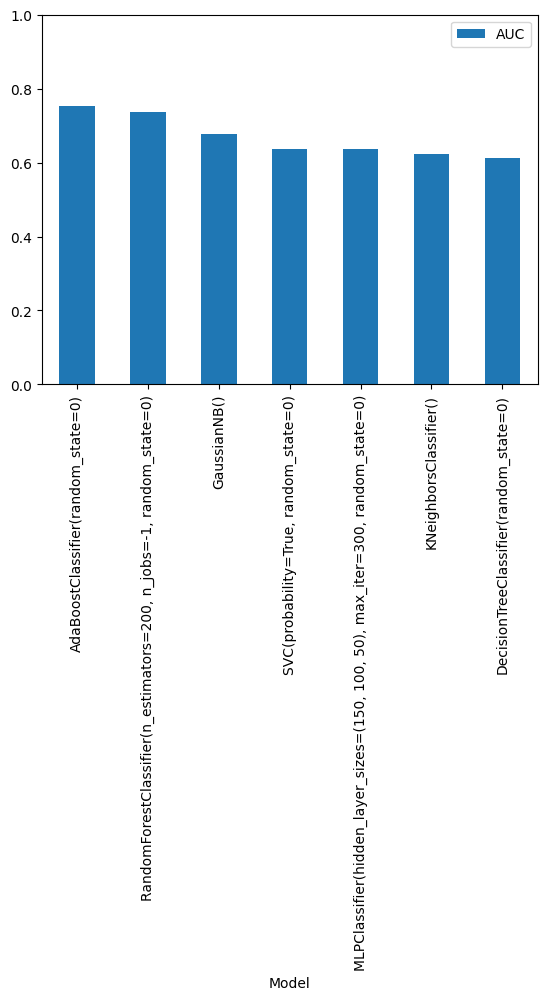

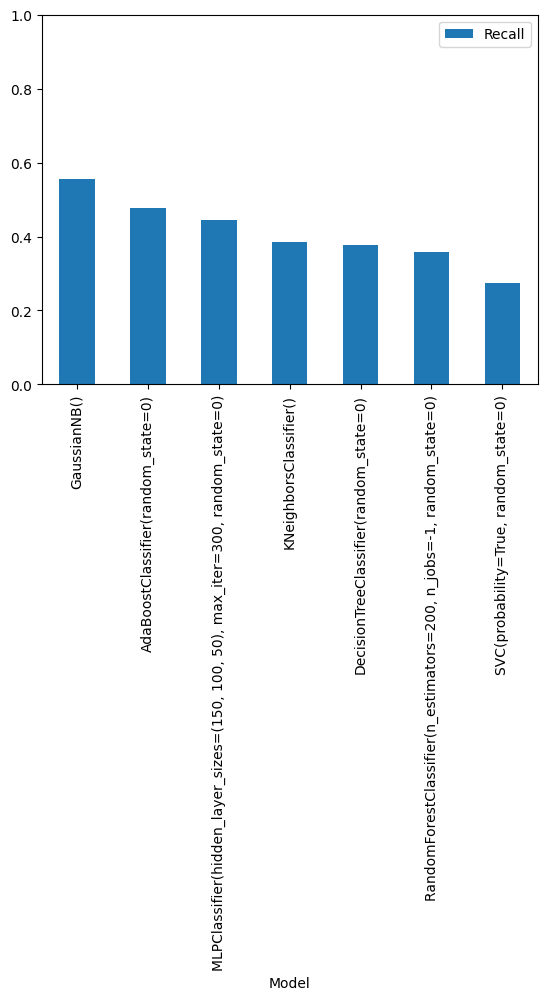

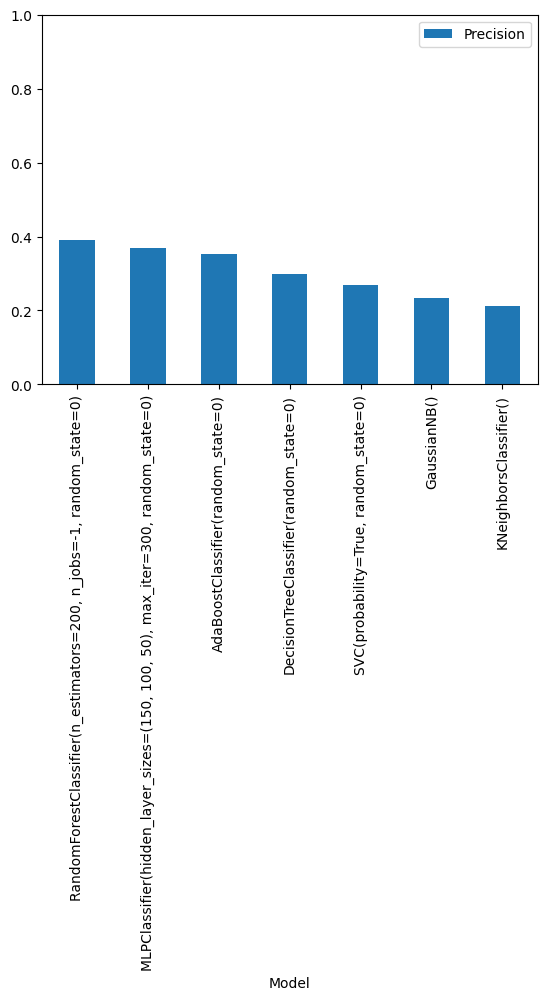

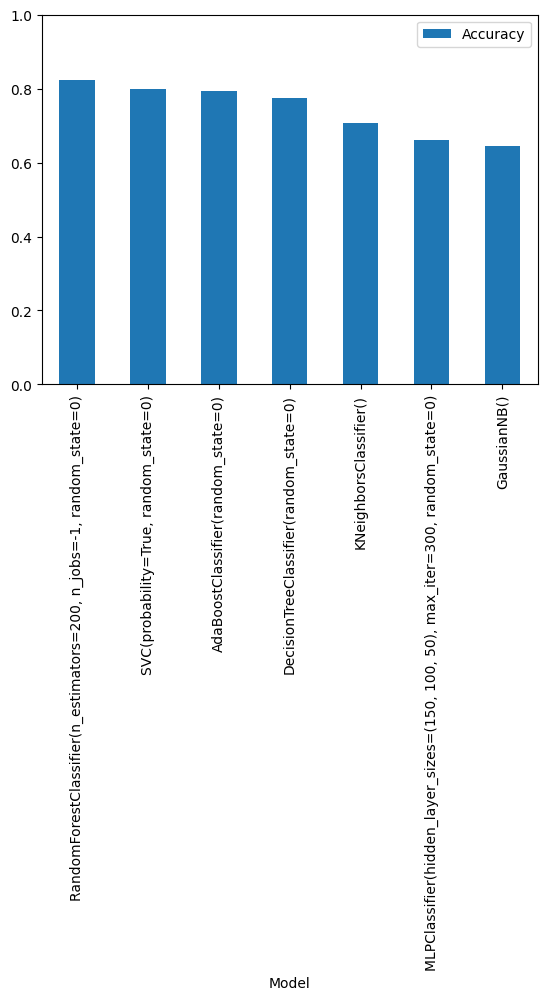

In [103]:
data = []
for a in sorted_aucs:
  model = a[0][2]
  auc = sum(a[1]) / len(a[1])
  data += [[str(model), auc]]

# bar plot data
df = pd.DataFrame(data, columns=["Model", "AUC"])
df = df.sort_values(by="AUC", ascending=False)
df = df.set_index("Model")
plot = df.plot.bar()
plot.set_ylim(0, 1.0)
print(plot)

data = []
for a in sorted(recalls.items(), key=lambda x: sum(x[1]), reverse=True):
  model = a[0][2]
  recall = sum(a[1]) / len(a[1])
  data += [[str(model), recall]]

# bar plot data
df = pd.DataFrame(data, columns=["Model", "Recall"])
df = df.sort_values(by="Recall", ascending=False)
df = df.set_index("Model")
plot = df.plot.bar()
plot.set_ylim(0, 1.0)
print(plot)

data = []
for a in sorted(precisions.items(), key=lambda x: sum(x[1]), reverse=True):
  model = a[0][2]
  precision = sum(a[1]) / len(a[1])
  data += [[str(model), precision]]

# bar plot data
df = pd.DataFrame(data, columns=["Model", "Precision"])
df = df.sort_values(by="Precision", ascending=False)
df = df.set_index("Model")
plot = df.plot.bar()
plot.set_ylim(0, 1.0)
print(plot)

data = []
for a in sorted(accuracies.items(), key=lambda x: sum(x[1]), reverse=True):
  model = a[0][2]
  accuracy = sum(a[1]) / len(a[1])
  data += [[str(model), accuracy]]

# bar plot data
df = pd.DataFrame(data, columns=["Model", "Accuracy"])
df = df.sort_values(by="Accuracy", ascending=False)
df = df.set_index("Model")
plot = df.plot.bar()
plot.set_ylim(0, 1.0)
print(plot)


#### Hyper parameter tuning the best pipeline

In [77]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 9)]
max_features = ['log2', 'sqrt', None]
max_depth = [int(x) for x in np.linspace(10, 80, num = 8)] + [None]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

x_train, x_test, y_train, y_test = train_test_split_unbalanced(loans_dev, "status", sampling_strategy="adasyn", \
          sort_by_date=False, train_ratio=0.8, random_state=0)

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)
rf_random.fit(x_train, y_train)
print(rf_random.best_params_)

# Extract best parameters
n_estimators = rf_random.best_params_['n_estimators']
max_features = rf_random.best_params_['max_features']
max_depth = rf_random.best_params_['max_depth']
min_samples_split = rf_random.best_params_['min_samples_split']
min_samples_leaf = rf_random.best_params_['min_samples_leaf']
bootstrap = rf_random.best_params_['bootstrap']

# Train and evaluate the model with the best parameters
auc_sum = 0
for random_state in range(no_different_splits):
    x_train, x_test, y_train, y_test = train_test_split_unbalanced(loans_dev, "status", sampling_strategy="adasyn", \
            sort_by_date=False, train_ratio=0.8, random_state=random_state)
    rf = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap, random_state=0)
    rf.fit(x_train, y_train)
    predictions_proba = rf.predict_proba(x_test)

    # Evaluate
    auc = roc_auc_score(y_test, predictions_proba[:, 1])
    print(auc)
    auc_sum += auc
print("Average AUC: " + str(auc_sum / no_different_splits))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   1.4s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   1.4s
[CV] END bootstrap=True, max_depth=40, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.6s
[CV] END bootstrap=False, max_depth=50, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=700; total time=   1.6s
[CV] END bootstrap=True, max_depth=70, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=800